<a href="https://colab.research.google.com/github/fhac-ewi/recurrent-neural-network/blob/Textprediction/%C3%9Cbung_RNN_L%C3%B6sung.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Übung RNN

## In dieser Übung ...
... werden wir ein bisschen lyrisch. Am Ende werden Sie vielleicht noch der nächste Shakespear






In [1]:
import tensorflow as tf
import keras
import numpy as np
import sys
import matplotlib.pyplot as plt
print("Keras Version:", keras.__version__, "; Tensorflow version:", tf.__version__, "; NumPy version:", np.__version__, "Python version:", ".".join(str(x) for x in sys.version_info[:3]))

from sklearn.model_selection import train_test_split

from datetime import datetime, timedelta
import time

Keras Version: 2.4.3 ; Tensorflow version: 2.3.0 ; NumPy version: 1.18.5 Python version: 3.6.9


## x.1 Erstellen und Vorbereiten eines eigenen Datensatzes 

Zuerst müssen wir ein paar Daten über die Werke von Shakespear besorgen

**Ihre Aufgaben**

Führen Sie die folgende Codezelle aus, betrachten Sie den Datensatz und überlegen Sie, was Sie mit den Daten noch tun müssen

Hinweis: Müssen Sie die Techte noch etwas bereinigen?

In [2]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [3]:
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



Wir werden der einfach heit halber einzelne Zeichen vorhersagen. Unser vokabular sollte also aus allen Zeichen bestehen, die im text vorkommen

Hinweis: Vielleicht kann https://spacy.io/usage/spacy-101 hilfreich sein

In [4]:
def tokenize(text):
    return list(text)

def untokenize(tokens):
    return "".join(tokens)

In [5]:
tokenized_text = tokenize(text)

tokens = sorted(set(tokenized_text))

print("Length of raw text:", len(text))
print("Length of tokenized text:", len(tokenized_text))
print("Unique tokens:", len(tokens))


Length of raw text: 1115394
Length of tokenized text: 1115394
Unique tokens: 65


## x.2 One Hot Kodierung

Für das Training unseres RNN werden wir eine One Hot kodierung nutzen

**Ihre Aufgaben**

(1) Implementieren Sie also eine Methode, die für Ihre ausgewählten Tokens eine one hot codierung erzeigt und diese Dann auf den Text anwendet

*Himweis:* Eine gute Idee könnte sein eine Klasse zu schreiben, die das vokabular specichert und onehot kodieren und dekodieren kann

In [6]:
class OneHot(object):
    def __init__(self, tokens, unknown_token = "[UNKNOWN]"):
        self.tokens = tokens
        self.unknown_token = unknown_token
        self.char_to_index = dict((token, i + 1) for i, token in enumerate(self.tokens))
        self.index_to_char = dict((i + 1, token) for i, token in enumerate(self.tokens))
        pass

    def encode(self, text_as_tokens, dtype=np.uint16):
        enc = np.empty((len(text_as_tokens), len(self.tokens) + 1), dtype=dtype)
        #enc = np.empty((len(text_as_tokens)), dtype=dtype)
        for i, token in enumerate(text_as_tokens):
            enc[i] = self.encode_token(token=token, l=len(self.tokens) + 1, dtype=dtype)
        return enc
    
    def encode_token(self, token, l, dtype=np.uint16):
        ret = np.zeros((1, l), dtype=dtype)
        if token not in self.char_to_index:
            ret[0, 0] = 1
            #return 1
        else:
            ret[0, self.char_to_index[token]] = 1
            #return self.char_to_index[token]
        return ret
    
    def decode(self, mat, unknown_token=None):            
        return [self.decode_token(mat[x]) for x in range(mat.shape[0])]
    
    def decode_token(self, vec, unknown_token=None):
        if unknown_token is None:
            unknown_token = self.unknown_token
        if isinstance(vec, tf.Tensor):
            vec = vec.numpy()
        if isinstance(vec, np.ndarray):
            am = np.argmax(vec)
        else:
            am = vec
        if am == 0:
            return unknown_token
        return self.index_to_char[am]

In [7]:
one_hot = OneHot(tokens=tokens)

In [8]:
one_hot_text = one_hot.encode(tokenized_text, dtype=np.bool_)

print(one_hot_text.shape, one_hot_text.dtype)

(1115394, 66) bool


(2) Für das training brauchen wir nun sequenzen einer bestimmten Länge, das heißt eine Abfolge gegebener Länge von Wörtern

Hinweis: Überlegen Sie sich wie lang Sie die Sequenz wählen wollen. Es sollte lang genug sein, dass das Netz zusammen hänge auch über mehrere Sätze lernen kann, aber nicht zu lang, sodass noch genug von den Daten übrig bleibt

In [9]:
sequence_len = 100
target_shape = (int(one_hot_text.shape[0] / (sequence_len + 1)) , (sequence_len + 1) , one_hot_text.shape[1])

one_hot_text_seq = np.empty(target_shape, dtype=one_hot_text.dtype)

for s in range(one_hot_text_seq.shape[0]):
    one_hot_text_seq[s] = one_hot_text[s * (sequence_len + 1):(s + 1) * (sequence_len + 1)]

(3) Nun müssen wir die Daten noch in X und Y aufteilen. Die Y-Werte sind die gleichen, wie die jeweiligen X-Daten, nur um 1 verschoben.

*Beispiel:* X: "Hallo Wel"; Y: "allo Welt"

*Hinweis:* Wenn Sie möchten können Sie hier auch schon in trainings und validierungsdaten aufteilen. Diese können während dem training zur Bewertung der Performance genutzt werden, das ist aber nicht nötig

In [10]:
VALIDATION_SIZE = 1/3

X_train, X_val, y_train, y_val = train_test_split(one_hot_text_seq[:, :-1], one_hot_text_seq[:, 1:], test_size=VALIDATION_SIZE)

print("X_train:", X_train.shape, X_train.dtype)
print("y_train:", y_train.shape, y_train.dtype)
print("X_val  :", X_val.shape, X_val.dtype)
print("y_val  :", y_val.shape, y_val.dtype)

print("-" * 25)
print(untokenize(one_hot.decode(X_train[0])))
print("-" * 25)
print(untokenize(one_hot.decode(y_train[0])))
print("-" * 25)

X_train: (7362, 100, 66) bool
y_train: (7362, 100, 66) bool
X_val  : (3681, 100, 66) bool
y_val  : (3681, 100, 66) bool
-------------------------
 comforter.

ANTONIO:
We two, my lord,
Will guard your person while you take your rest,
And watch yo
-------------------------
comforter.

ANTONIO:
We two, my lord,
Will guard your person while you take your rest,
And watch you
-------------------------


## x.3 Erstellen des RNN Modells

Hier erstellen wir das eigentliche RNN. Hierfür nutzen wir ein Sequential Model von Keras mit einem RNN und einem Dense Layer mit Softmax zum erstellen der Ausgabe.

**Ihre Aufgaben**

(1) Erstellen Sie das entsprechende Sequential model. Empfehlung mit adam und categorical_crossentropy. Fügen Sie bei den metrics auch 'accuracy' hinzu. Die werden wir später nutzen

In [11]:
# Length of the vocabulary in chars
vocab_size = X_train.shape[-1]

# The input shape
lstn_input_shape = X_train.shape[1:]

# Number of RNN units
rnn_units = 1024

In [12]:
SELECTED_ARCH = tf.keras.layers.SimpleRNN

model = tf.keras.Sequential()
model.add(SELECTED_ARCH(rnn_units, return_sequences=True, input_shape=lstn_input_shape, name="The_Brain"))
model.add(tf.keras.layers.Dense(vocab_size, activation='softmax', name="The_Hand"))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

input_example_batch = X_train[0]
input_example_batch = input_example_batch.reshape((1, *input_example_batch.shape))

example_batch_predictions = model.predict(input_example_batch)
print(input_example_batch.shape, y_train[0].shape, example_batch_predictions.shape)

print("Test sequence:", "\n", "-" * 25, "\n", untokenize(one_hot.decode(X_train[0])), "\n", "-"*25)
print("Expected result:", "\n", "-" * 25, "\n", untokenize(one_hot.decode(y_train[0])), "\n", "-"*25)
print("Untrained prediction:", "\n", "-" * 25, "\n", untokenize(one_hot.decode(example_batch_predictions[0])), "\n", "-"*25)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
The_Brain (SimpleRNN)        (None, 100, 1024)         1117184   
_________________________________________________________________
The_Hand (Dense)             (None, 100, 66)           67650     
Total params: 1,184,834
Trainable params: 1,184,834
Non-trainable params: 0
_________________________________________________________________
(1, 100, 66) (100, 66) (1, 100, 66)
Test sequence: 
 ------------------------- 
  comforter.

ANTONIO:
We two, my lord,
Will guard your person while you take your rest,
And watch yo 
 -------------------------
Expected result: 
 ------------------------- 
 comforter.

ANTONIO:
We two, my lord,
Will guard your person while you take your rest,
And watch you 
 -------------------------
Untrained prediction: 
 ------------------------- 
 LJJIZlokEs&KJyFs$V-MF?t.3GhQ!IbDLmDKzFSnVgmam$d&scJQFFUoHlgFFRSdBBWl:G

## x.4 Training eines RNN Modells

Nun gehts ans trainieren. Nutzen Sie für den Anfang eine kleine Anzahl an epochen um herauszufinden wie viele Sie in einer ertragbaren Zeit machen können. Sollten Sie auf google Colab arbeiten könnte 20 hier ein guter Startwert sein

**Ihre Aufgaben**

(1) Nutze die Fit methode deines models um es auf den ertellten Trainingsdaten zu trainieren. Wenn Sie validierungsdaten erzeugt haben können Sie diese bei validation_data angeben. Um die Trainingszeit kurz zu halten kann es auch Sinn ergeben hier eine batch_size anzugeben

In [13]:
EPOCHS = 20

t1 = time.time()
hist = model.fit(X_train, y_train,
                  batch_size=64,
                  epochs=EPOCHS,
                  validation_data=(X_val, y_val))
t2 = time.time()

print("Training took:", timedelta(seconds=t2-t1))

Epoch 1/20
116/116 [==============================] - 11s 93ms/step - loss: 3.2454 - accuracy: 0.1751 - val_loss: 2.8825 - val_accuracy: 0.2534
Epoch 2/20
116/116 [==============================] - 10s 86ms/step - loss: 2.7295 - accuracy: 0.2867 - val_loss: 2.5684 - val_accuracy: 0.3160
Epoch 3/20
116/116 [==============================] - 10s 88ms/step - loss: 2.4247 - accuracy: 0.3324 - val_loss: 2.3222 - val_accuracy: 0.3365
Epoch 4/20
116/116 [==============================] - 10s 90ms/step - loss: 2.2410 - accuracy: 0.3633 - val_loss: 2.2375 - val_accuracy: 0.3703
Epoch 5/20
116/116 [==============================] - 10s 90ms/step - loss: 2.1443 - accuracy: 0.3870 - val_loss: 2.1682 - val_accuracy: 0.3839
Epoch 6/20
116/116 [==============================] - 10s 88ms/step - loss: 2.0653 - accuracy: 0.4066 - val_loss: 2.0882 - val_accuracy: 0.3984
Epoch 7/20
116/116 [==============================] - 10s 82ms/step - loss: 2.0134 - accuracy: 0.4186 - val_loss: 2.0725 - val_accuracy:

(2) Plotten Sie accuracy und loss über die Epochen um bewerten zu können wie gut das Training lief

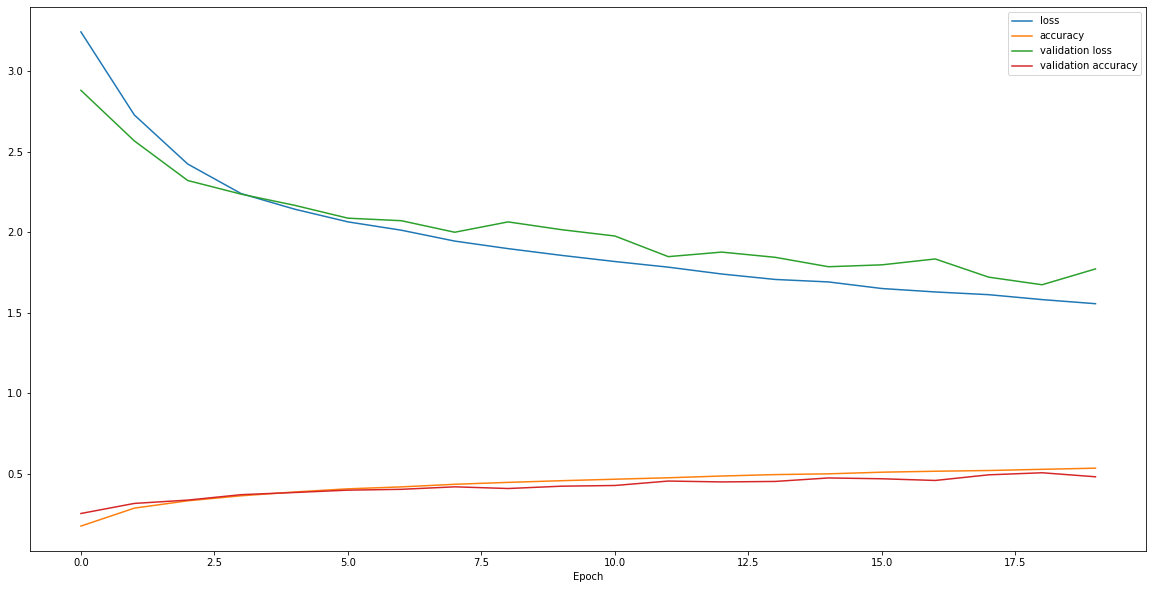

In [14]:
fig, ax = plt.subplots(1, 1)

ax.plot(hist.history["loss"], label='loss')
ax.plot(hist.history["accuracy"], label='accuracy')
ax.plot(hist.history["val_loss"], label='validation loss')
ax.plot(hist.history["val_accuracy"], label='validation accuracy')
ax.set_xlabel("Epoch")
ax.legend()

fig.set_size_inches(20, 10)

plt.show()

## x.5 Text prediction

(1) Schreiben Sie eine Methode, die für einen gegebenen Text das nächste Zeichen prognostiziert

In [15]:
def predict(txt, one_hot, trainied_model):
    encoded_txt = one_hot.encode(tokenize(txt))
    prediction = trainied_model.predict(encoded_txt.reshape((1, *encoded_txt.shape)))
    return untokenize(one_hot.decode(prediction[0]))[-1]

(2) *Optional:* Nutzen Sie ipywidgets um live vorschläge zurück zu geben

In [16]:
import ipywidgets as widgets
from IPython.display import display

In [17]:
def verbose_prediction(txt, one_hot, trainied_model):
    if len(txt) == 0:
        txt = " "
    prediction = predict(txt=txt, one_hot=one_hot, trainied_model=trainied_model)
    print(f"I think the next will be \"{prediction}\" after you said \"{txt}\"")

w = widgets.interactive(verbose_prediction,
                        txt=widgets.Text(value='Hello Worl', placeholder='Type something', description='Your text:', disabled=False),
                        one_hot=widgets.fixed(one_hot),
                        trainied_model=widgets.fixed(model),
                       )
display(w)

interactive(children=(Text(value='Hello Worl', description='Your text:', placeholder='Type something'), Output…

## x.6 *Optional* Vergleich mit LSTM und GRU und ...

Trainieren Sie nun modelle mit LSTM und GRU oder anderen Architekturen und vergleichen Sie lernperformance und Ergebnisse. Was fällt Ihnen auf?

## x.7 *Noch Optionaler* Ist das Netz jetzt ein Schriftsteller?

Was müsste man ändern um nun ein ganzes Buch erstellen zu lassen? Glauben Sie das Ergebniss wäre lesbar?